In [29]:
from getpass import getpass
from glob import glob

import numpy as np
import pylab as plt
from astropy import stats, units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.ticker import MaxNLocator
%matplotlib inline

import pandas as pd
from scipy.interpolate import interp1d
from scipy.signal import gaussian, convolve
from statistics import median

from scipy.optimize import curve_fit, least_squares

import utils

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# plotting setup
fontsize = 14
plt.rcParams['font.size'] = fontsize
plt.rcParams['axes.titlesize'] = fontsize

In [2]:
import var
from astropy.io import fits

In [3]:
objname = '150023_1179'
res=qc.query(sql="""SELECT meas.* 
                    FROM nsc_dr2.meas
                    WHERE objectid='{:s}'""".format(objname),
             fmt='pandas',
             profile='db01')
res[:5]

,mjd,ra,dec,x,y,raerr,decerr,mag_auto,magerr_auto,mag_aper1,...,theta,thetaerr,fwhm,class_star,ccdnum,flags,measid,objectid,exposure,filter
0,57113.103622,184.660012,-31.714284,1925.4500,3753.07,0.013498,0.012326,16.4367,0.002352,17.5287,...,102.5060,16.88590,1.015290,0.988802,19,0,c4d.426837.19.111,150023_1179,c4d_150401_023233_ooi_r_v1,r
1,57113.056146,184.660014,-31.714282,1916.1600,3738.60,0.017272,0.014770,16.6075,0.002451,17.7974,...,94.8063,-2.10764,1.093830,0.983845,19,0,c4d.426814.19.143,150023_1179,c4d_150401_012411_ooi_i_v1,i
2,57112.054908,184.660013,-31.714283,1910.2000,3754.76,0.014560,0.011941,16.6778,0.002346,17.9072,...,82.5395,-81.96120,1.143730,0.988209,19,0,c4d.426474.19.118,150023_1179,c4d_150331_012224_ooi_r_v1,r
3,56736.267460,184.660019,-31.714281,561.9940,1717.94,0.018848,0.017301,16.7528,0.013090,17.7609,...,149.2020,-55.76460,0.960298,0.983257,19,0,c4d.294386.19.444,150023_1179,c4d_140320_062622_ooi_Y_v1,Y
4,57100.221888,184.660015,-31.714279,38.7759,2497.93,0.013784,0.014180,16.9189,0.007564,17.9516,...,165.4620,-61.81470,0.998975,0.990544,46,0,c4d.423324.46.763,150023_1179,c4d_150319_052119_ooi_r_v1,r


In [4]:
def get_data(df,band='r ',aper=1):
    fltr = (df['filter'] == band)
    fwhm = (df['fwhm'] <= 4.0)
    sel = fltr & fwhm
    #sel = (df['filter'] == band)
    t = df['mjd'][sel].values
    y = df['mag_auto'][sel].values
    dy = df['magerr_auto'][sel].values
    return t,y,dy # return time, magnitudes in one band, uncertainties

def get_folded_phase(t,best_period,offset=0):
    
    """Fold the observation times with the best period of the variable signal."""
    
    # light curve over period, take the remainder (i.e. the "phase" of one period)
    phase = (t / best_period - offset) % 1
    
    return phase

def smooth(x,y,s=80):
    """
    Convolves with a gaussian to create a smoothe line.
    """
    f = interp1d(x,y)
    xx = np.linspace(min(x),max(x),2000)
    yy = f(xx)
    window = gaussian(200,s)
    smoothed = convolve(yy, window/window.sum(), mode='same')
    return xx,smoothed

In [5]:
import collections
collections.Counter(res['filter'])

Counter({'r': 64, 'i': 61, 'Y': 3, 'g': 73, 'z': 10, 'u': 10})

In [6]:
tr,yr,dyr = get_data(res,'r')
tg,yg,dyg = get_data(res,'g')
ti,yi,dyi = get_data(res,'i')

period = 0.5982

gcrv = np.vstack((tg,yg-min(yg),dyg)).T
gcrv = gcrv[gcrv[:,0].argsort()]

rcrv = np.vstack((tr,yr-min(yr),dyr)).T
rcrv = rcrv[rcrv[:,0].argsort()]

icrv = np.vstack((ti,yi-min(yi),dyi)).T
icrv = icrv[icrv[:,0].argsort()]

In [7]:
gtmps = glob('templets/*g.dat')
gtemplets = np.zeros((len(gtmps),501,2))
for i in range(len(gtmps)):
    gtemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(gtmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [8]:
rtmps = glob('templets/*r.dat')
rtemplets = np.zeros((len(rtmps),501,2))
for i in range(len(rtmps)):
    rtemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(rtmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [9]:
itmps = glob('templets/*i.dat')
itemplets = np.zeros((len(itmps),501,2))
for i in range(len(itmps)):
    itemplets[i] = np.concatenate((np.array([[0,0]]),
                                   np.array(pd.read_csv(itmps[i],sep=' ')),
                                   np.array([[1,0]])))

In [11]:
class tmpfitter:
    def __init__ (self, tmps):
        self.n=0
        self.tmps=tmps
    
    def model(self, t, period, phase, amplitude, yoffset):
        # modify the template using phase, amplitude, yoffset
        xtemp = self.tmps[self.n,:,0]
        ytemp = self.tmps[self.n,:,1]*amplitude + yoffset
        ph = (t / period - phase)%1
        # interpolate the modified template to the phase we want
        return interp1d(xtemp,ytemp)(ph)
    
def tmpfit(tmps,crv,pinit):
    datfit = []
    npars = []
    fitter = tmpfitter(tmps)
    for i in range(len(tmps)):
        fitter.n = i
        pars, cov = curve_fit(fitter.model, crv[:,0], crv[:,1],sigma=crv[:,2],p0=pinit)
        datfit.append(median(abs(fitter.model(crv[:,0],pars[0],pars[1],pars[2],pars[3])-crv[:,1])))
        npars.append(pars)
    n = np.argmin(datfit)
    return n, npars[n]

In [12]:
y0=min(gcrv[:,1])
y1=max(gcrv[:,1])
t0=gcrv[np.argmin(gcrv[:,1]),0]/period%1
pinit = (period,t0,y1-y0,y0)
gn,gpars = tmpfit(gtemplets,gcrv,pinit)
gpars

array([0.59820011, 0.92566437, 0.74577755, 0.06828474])

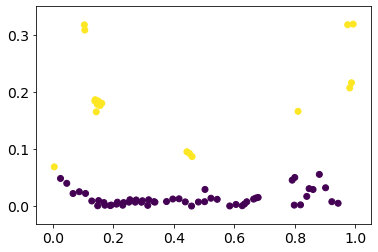

In [31]:
f = interp1d(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3])
phase_g = (gcrv[:,0]/gpars[0]-gpars[1])%1
dif = abs(gcrv[:,1]-f(phase_g))
plt.scatter(phase_g,dif,c=dif>utils.mad(dif)*4)

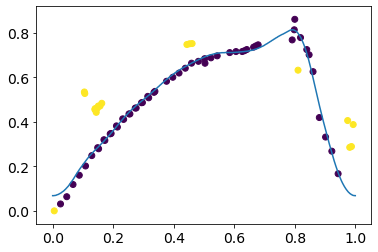

In [32]:
plt.scatter(phase_g,gcrv[:,1],c=dif>utils.mad(dif)*4)
plt.plot(gtemplets[gn,:,0],gtemplets[gn,:,1]*gpars[2]+gpars[3])

In [ ]:
#res = least_squares(poly_resid, initpar, loss=loss, f_scale=0.1, args=(x,y,sigma), max_nfev=max_nfev)

In [15]:
#gcrv = gcrv[dif<np.std(dif)*3]

In [16]:
"""
gcrv = np.tile(gcrv.T,2).T
gcrv[int(len(gcrv)/2):,0] += 1
rcrv = np.tile(rcrv.T,2).T
rcrv[int(len(rcrv)/2):,0] += 1
icrv = np.tile(icrv.T,2).T
icrv[int(len(icrv)/2):,0] += 1

gtemplets = np.tile(gtemplets,(2,1))
gtemplets[:,int(len(gtemplets[0])/2):,0] += 1
rtemplets = np.tile(rtemplets,(2,1))
rtemplets[:,int(len(rtemplets[0])/2):,0] += 1
itemplets = np.tile(itemplets,(2,1))
itemplets[:,int(len(itemplets[0])/2):,0] += 1
"""

'\ngcrv = np.tile(gcrv.T,2).T\ngcrv[int(len(gcrv)/2):,0] += 1\nrcrv = np.tile(rcrv.T,2).T\nrcrv[int(len(rcrv)/2):,0] += 1\nicrv = np.tile(icrv.T,2).T\nicrv[int(len(icrv)/2):,0] += 1\n\ngtemplets = np.tile(gtemplets,(2,1))\ngtemplets[:,int(len(gtemplets[0])/2):,0] += 1\nrtemplets = np.tile(rtemplets,(2,1))\nrtemplets[:,int(len(rtemplets[0])/2):,0] += 1\nitemplets = np.tile(itemplets,(2,1))\nitemplets[:,int(len(itemplets[0])/2):,0] += 1\n'